In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
train_x = pd.read_csv('data/training_signals.csv', index_col=0)
train_y = pd.read_csv('data/training_labels.csv', index_col=0)
test_x = pd.read_csv('data/testing_signals.csv', index_col=0)
test_y = pd.read_csv('data/testing_labels.csv', index_col=0)

In [3]:
train_x.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-5.004000e-07,0.000001,-0.000014,0.000006,-0.000005,9.756200e-07,5.053400e-07,1.868200e-08,-0.000002,0.000031,8.900800e-07,0.000007
1,1.707100e-07,0.000003,-0.000014,0.000003,-0.000008,1.143500e-06,2.687500e-06,1.871000e-08,-0.000002,0.000023,2.568800e-06,0.000005
2,8.418200e-07,0.000004,-0.000013,-0.000003,-0.000008,3.829100e-06,2.519900e-06,1.873700e-08,-0.000003,0.000012,-1.165600e-07,0.000002


In [4]:
train_x, train_y = train_x.values, train_y.values.ravel()
test_x, test_y = test_x.values, test_y.values.ravel()

In [5]:
# Add (model_title) as key and (model_class) as value and it will work if you want to try more
models_dict = {
    'Logistic Regression':LogisticRegression, 
    'Linear Discriminant\nAnalysis':LinearDiscriminantAnalysis, 
    'Quadratic Discriminant\nAnalysis':QuadraticDiscriminantAnalysis,
#     'K-Nearest Neighbors':KNeighborsClassifier, 
#     'Support Vector Machine\nRadial Basis Function':SVC
}

def plot_acc(train_x, train_y, test_x, test_y, models=list(models_dict.keys()), 
             ax=None, fig=None, title=None, y_off=3, savename=None):
    # set colormaps
    cmap = cm.viridis
    cmap2 = cm.magma_r
    if not ax:  # create figure if not passed
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    
    # for each model, use each of the training data and testing data to evaluate the model
    for m_idx, model_name in tqdm(enumerate(models)):
        for data_idx, (score_x, score_y) in enumerate([[train_x, train_y], [test_x, test_y]]) :
            model = models_dict[model_name](kernel='rbf') if 'Support' in model_name else models_dict[model_name]()
            model.fit(train_x, train_y)
            score = model.score(score_x, score_y)
            
            # select the proper bar color, plot the bar, annotate the accuracy on it, and add the model title
            color = cmap(score) if data_idx == 0 else cmap2(score)
            ax.bar(x=0.1+m_idx/(len(models)+1)+data_idx*0.05, height=score*100, 
                   width=0.125/len(models), color=color)
            ax.annotate(f'{score*100:0.3f}', xy=(0.1+m_idx/(len(models)+1)+data_idx*0.05, score*100-y_off), 
                        size=18, ha='center', color='white' if data_idx==0 else 'black')
            ax.text(x=0.1+m_idx/(len(models)+1)+0.025, y=-3, s=model_name, ha='center', va='top', 
                    size=18, rotation=0)

    ax.set_ylim(0, 100)
    ax.set_yticklabels(ax.get_yticks(), size=18)
    ax.set_xticks([])
    
    if title:  # set the figure title if it is passed
        ax.set_title(title, size=28)
    if savename:  # save the figure if a savename is passed
        fig.savefig(savename, bbox_inches='tight')

3it [00:00,  3.30it/s]


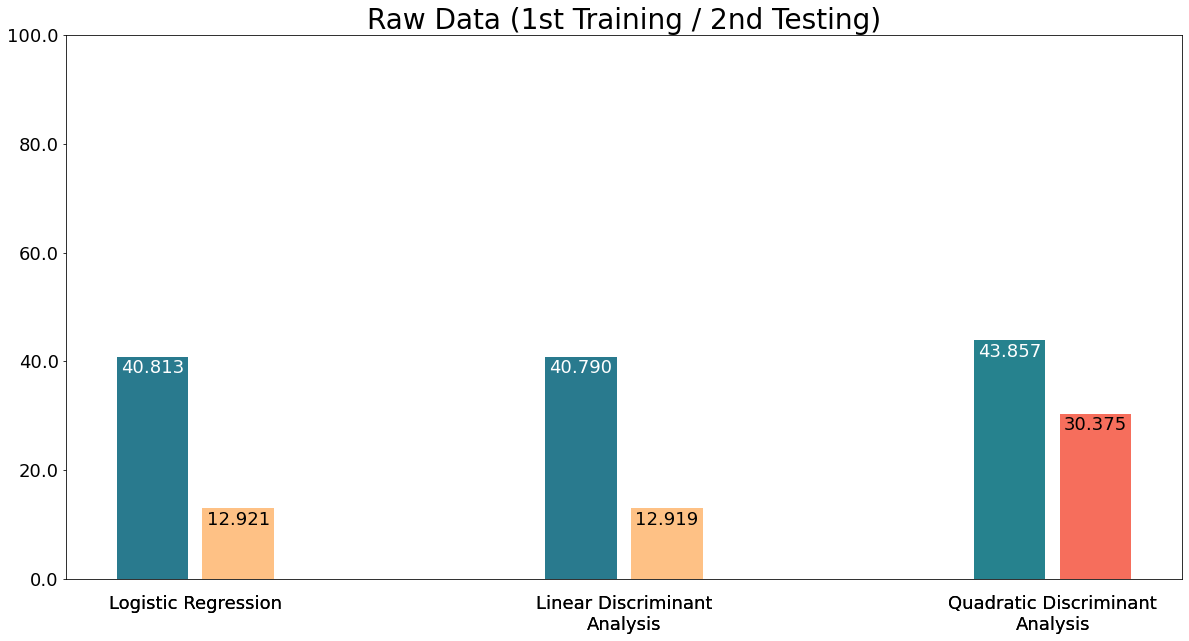

In [6]:
# use small subset to compare with the pipeline processing
plot_acc(train_x[:100000, :], train_y[:100000], test_x[:100000, :], test_y[:100000], savename='raw_data.jpg', 
         title='Raw Data (1st Training / 2nd Testing)')

# The Pipeline Class

In [7]:
# install UMAP library
!pip install umap-learn

from umap import UMAP
from sklearn.decomposition import PCA

In [8]:
def UMAP_(n_components=16, n_neighbors=20, metric='correlation', output_metric='euclidean', 
             target_metric='categorical'):
    return UMAP(a=None, angular_rp_forest=True, b=None,
                force_approximation_algorithm=False, init='random', learning_rate=1,
                local_connectivity=0.0, low_memory=False, metric=metric,
                metric_kwds=None, min_dist=0.025, n_components=n_components, n_epochs=400,
                n_neighbors=n_neighbors, negative_sample_rate=5, output_metric=output_metric,
                output_metric_kwds=None, random_state=42, repulsion_strength=3,
                set_op_mix_ratio=1.0, spread=10.0, target_metric=target_metric,
                target_metric_kwds=None, target_n_neighbors=-1, target_weight=.75,
                transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)


class FDA:
    def __init__(self):
        self.W = None
        
    def fit(self, x, y):
        tot_var = np.cov(x.T)
        intra_var = 0
        classes = y
        for class_num in np.unique(classes):
            class_data = x[(classes == class_num).ravel()]
            class_var = np.cov(class_data.T)
            intra_var += class_var
            
        inter_var = tot_var - intra_var
        
        Q = np.linalg.inv(intra_var) @ inter_var
        _, self.W = np.linalg.eig(Q)
        
    def transform(self, x):
        return (self.W.T @ x.T).T
    
    def fit_transform(self, x, y):
        self.fit(x, y)
        return self.transform(x)


class Pipeline:
    def __init__(self, proc_names=(), n_components=16, processors_dict=None):
        self.proc_names = proc_names
        self.processors = []
        self.fitted = False
        self.processors_dict = copy(processors_dict) if processors_dict else {
            'umap': UMAP_(n_components=n_components, n_neighbors=2, metric='cosine', 
                          output_metric='euclidean', target_metric='euclidean'),
            'pca': PCA(n_components=n_components),
            'fda': FDA(),
        }
                    
    def fit(self, x, y=None, transform=False):
        x_original = np.copy(x)
        for proc_name in self.proc_names:
            processor = self.processors_dict[proc_name] if isinstance(proc_name, str) else proc_name     
            if proc_name in ['umap', 'pca', 'kpca', 'fda', 's_pca', 'norm', 'kfda', 'kdm', 'anm']:
                y = np.argmax(y, axis=1) if y.ndim != 1 else y
            elif proc_name in ['spca', 'spca', 'kfda', 'kspca']:
                y = y.reshape(-1, 1) if y.ndim == 1 else y
            
            if proc_name == 'con':
                x = processor.fit_transform(x, y=y, x_original=x_original)
            else:
                x = processor.fit_transform(x, y=y) if proc_name != 'plssvd' else processor.fit_transform(x, y=y)[-1]
            self.processors.append(processor)
        
        self.fitted = True
        if transform:
            return x
        else:
            return self
        
    def transform(self, x):
        x_original = np.copy(x)
        for proc_name, processor in zip(self.proc_names, self.processors):
            if proc_name == 'con':
                x = processor.transform(x, x_original=x_original)
            else:
                x = processor.transform(x) if proc_name != 'plssvd' else processor.transform(x)[-1]
        return x
    
    def fit_transform(self, x, y=None):
        return self.fit(x, y, transform=True)
    
    def process_data(self, raw_x, raw_y, unseen_raw_x=(), unseen_raw_y=(), gesture_label=None, original_labels=True):
        x, y = raw_x, raw_y
        unseen_x, unseen_y = copy(unseen_raw_x), copy(unseen_raw_y)

        if gesture_label:
            y = y[:, gesture_label-1]
            for idx, unseen_labels in enumerate(unseen_y):
                unseen_y[idx] = unseen_labels[:, gesture_label-1]

        x = self.fit_transform(x, y=y)
        for idx, unseen_data in enumerate(unseen_x):
            unseen_x[idx] = self.transform(unseen_data)

        return x, (raw_y if original_labels else y), unseen_x, (unseen_raw_y if original_labels else unseen_y)

In [9]:
# use a small set of data only (takes a couple of minutes) or the kernel crashes (use colab. it might work)
# create pipeline and fit it
pipeline = Pipeline(proc_names=['fda', 'pca', 'umap'], n_components=train_x.shape[1])
pipeline.fit(train_x[:100000], train_y[:100000])

# transform the training and testing data (labels stay the same)
proc_train_x = pipeline.transform(train_x[:100000])
proc_test_x = pipeline.transform(test_x[:100000])

3it [00:02,  1.25it/s]


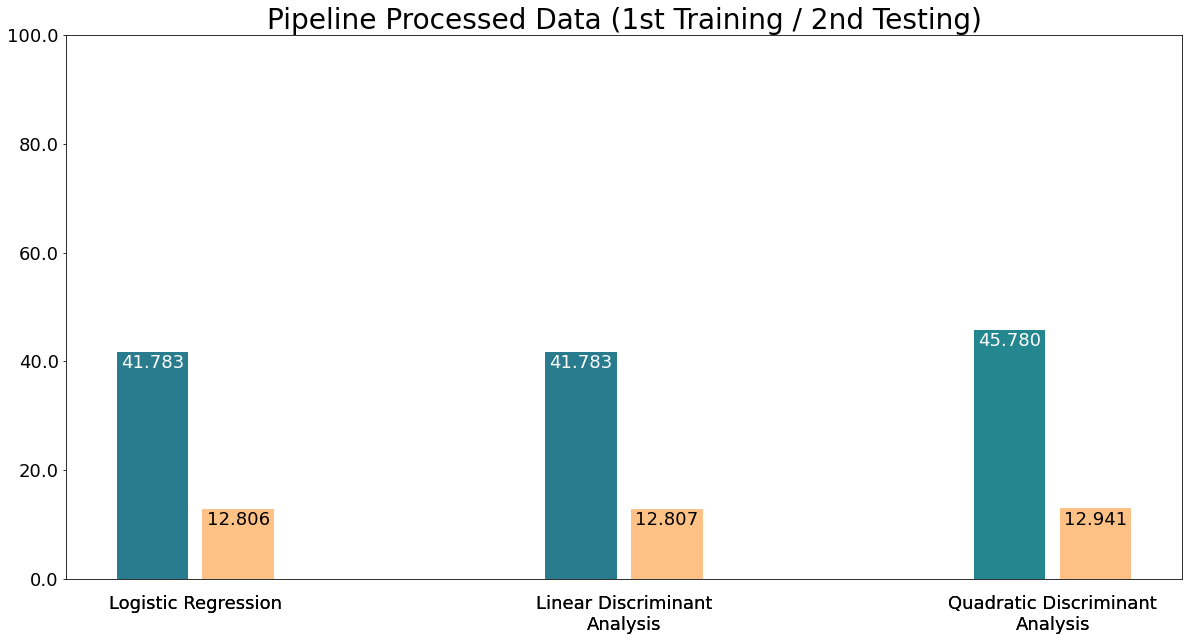

In [10]:
plot_acc(proc_train_x, train_y[:100000], proc_test_x, test_y[:100000], savename='proc_data.jpg',
         title='Pipeline Processed Data (1st Training / 2nd Testing)')